In [0]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Row
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, BucketedRandomProjectionLSH, VectorAssembler, StandardScaler, MinMaxScaler, Imputer
from pyspark.ml.linalg import VectorUDT, DenseVector, SparseVector
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.neighbors import KDTree

from functools import reduce
from imblearn.over_sampling import SMOTENC
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

### Loading Data

In [0]:
df_vehicle_insurance = spark.read.format('csv').option('header','true').load('/mnt/team12/aug_train.csv')
df_vehicle_insurance.cache()

df_airplane = spark.read.format('csv').option('header','true').load('/mnt/team12/airline.csv')
df_airplane.cache()

Out[2]: DataFrame[ActualElapsedTime: string, AirTime: string, ArrDelay: string, ArrTime: string, CRSArrTime: string, CRSDepTime: string, CRSElapsedTime: string, CancellationCode: string, Cancelled: string, CarrierDelay: string, DayOfWeek: string, DayofMonth: string, DepDelay: string, DepTime: string, Dest: string, Distance: string, Diverted: string, FlightNum: string, LateAircraftDelay: string, Month: string, NASDelay: string, Origin: string, SecurityDelay: string, TailNum: string, TaxiIn: string, TaxiOut: string, UniqueCarrier: string, WeatherDelay: string, Year: string]

### Pre-Processing

**Vehicle Dataset**

In [0]:
df_vehicle_insurance = df_vehicle_insurance.drop('Region_Code', 'Policy_Sales_Channel')
si = StringIndexer(inputCols=['Gender','Vehicle_Damage', 'Vehicle_Age'],
                   outputCols=['Gender_Idx','Vehicle_Damage_Idx', 'Vehicle_Age_Idx']).fit(df_vehicle_insurance)
indexed_df = si.transform(df_vehicle_insurance).select('Age', 'Annual_Premium', 'Vintage', 'Driving_License',
                                          'Previously_Insured', F.col('Gender_Idx').alias('Gender'),
                                          F.col('Vehicle_Damage_Idx').alias('Vehicle_Damage'),
                                          F.col('Vehicle_Age_Idx').alias('Vehicle_Age'), 'Response')
clean_df = indexed_df.select([F.col(c).cast('float').alias(c) for c in indexed_df.columns])

@F.udf(T.FloatType())
def fix_vehicle_age_encoding(x):

  if x == 2.0:
    return x
  
  return 1.0 - x


clean_df = clean_df.select("*", fix_vehicle_age_encoding(F.col('Vehicle_Age')).alias('Vehicle_Age_Fixed')) \
    .drop('Vehicle_Age').withColumnRenamed('Vehicle_Age_Fixed', 'Vehicle_Age')

assembler = VectorAssembler(inputCols=[col for col in clean_df.columns if col != 'Response'], outputCol='features')
features_df = assembler.transform(clean_df).select('features', 'Response')
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')
model = scaler.fit(features_df)
scaled_features_df = model.transform(features_df).select(F.col('scaledFeatures').alias('features'), 'Response')

scaled_df = scaled_features_df.select(vector_to_array(F.col('features')).alias('fs'), 'Response').select([F.col('fs')[i] for i in range(8)] + ['Response'])
original_column_names = [col for col in clean_df.columns if col != 'Response']
columns_to_change = [col for col in scaled_df.columns if col != 'Response']
scaled_vehicle_df = reduce(lambda scaled_df, idx: scaled_df.withColumnRenamed(columns_to_change[idx], original_column_names[idx]), range(len(columns_to_change)), scaled_df)

In [0]:
scaled_vehicle_df.groupBy('Response').count().show()

+--------+------+
|Response| count|
+--------+------+
|     1.0| 62601|
|     0.0|319553|
+--------+------+



**Airplane Dataset**

In [0]:
df_airplane = df_airplane.drop('CancellationCode', 'FlightNum', 'Dest', 'Origin', 'TailNum', 'UniqueCarrier')
df_airplane = df_airplane.withColumn('CarrierDelay', F.regexp_replace('CarrierDelay', 'NA', '0')) \
  .withColumn('DepDelay', F.regexp_replace('DepDelay', 'NA', '0')) \
  .withColumn('LateAircraftDelay', F.regexp_replace('LateAircraftDelay', 'NA', '0')) \
  .withColumn('NASDelay', F.regexp_replace('NASDelay', 'NA', '0')) \
  .withColumn('SecurityDelay', F.regexp_replace('SecurityDelay', 'NA', '0')) \
  .withColumn('WeatherDelay', F.regexp_replace('WeatherDelay', 'NA', '0'))

df_airplane = df_airplane.withColumn('ActualElapsedTime', F.regexp_replace('ActualElapsedTime', 'NA', "nan")) \
  .withColumn('AirTime', F.regexp_replace('AirTime', 'NA', "nan")) \
  .withColumn('ArrDelay', F.regexp_replace('ArrDelay', 'NA', "nan")) \
  .withColumn('ArrTime', F.regexp_replace('ArrTime', 'NA', "nan")) \
  .withColumn('CRSElapsedTime', F.regexp_replace('CRSElapsedTime', 'NA', "nan")) \
  .withColumn('DepTime', F.regexp_replace('DepTime', 'NA', "nan")) \
  .withColumn('Distance', F.regexp_replace('Distance', 'NA', "nan")) \
  .withColumn('TaxiIn', F.regexp_replace('TaxiIn', 'NA', "nan")) \
  .withColumn('TaxiOut', F.regexp_replace('TaxiOut', 'NA', "nan"))

df_airplane = df_airplane.select([F.col(c).cast('float').alias(c) for c in df_airplane.columns])

imputer = Imputer(inputCols=['ActualElapsedTime', 'AirTime', 'ArrDelay', 'ArrTime', 'CRSElapsedTime', 'DepTime', 'Distance', 'TaxiIn', 'TaxiOut'], outputCols=['ActualElapsedTime', 'AirTime', 'ArrDelay', 'ArrTime', 'CRSElapsedTime', 'DepTime', 'Distance', 'TaxiIn', 'TaxiOut'])
model = imputer.fit(df_airplane)
imputed_airplane_df = model.transform(df_airplane)

assembler = VectorAssembler(inputCols=[col for col in imputed_airplane_df.columns if col != 'Cancelled'], outputCol='features')
features_airplane_df = assembler.transform(imputed_airplane_df).select('features', 'Cancelled')
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')
model = scaler.fit(features_airplane_df)
scaled_features_df = model.transform(features_airplane_df).select(F.col('scaledFeatures').alias('features'), 'Cancelled')

scaled_df = scaled_features_df.select(vector_to_array(F.col('features')).alias('fs'), 'Cancelled').select([F.col('fs')[i] for i in range(len(imputed_airplane_df.columns) - 1)] + ['Cancelled'])
original_column_names = [col for col in imputed_airplane_df.columns if col != 'Cancelled']
columns_to_change = [col for col in scaled_df.columns if col != 'Cancelled']
scaled_airplane_df = reduce(lambda scaled_df, idx: scaled_df.withColumnRenamed(columns_to_change[idx], original_column_names[idx]), range(len(columns_to_change)), scaled_df)

smaller_scaled_airplane_df = scaled_airplane_df.limit(1000000)

In [0]:
smaller_scaled_airplane_df.groupBy('Cancelled').count().show()

+---------+------+
|Cancelled| count|
+---------+------+
|      0.0|981110|
|      1.0| 18890|
+---------+------+



## Utilities

Any utility functions are defined here, balance_score, classifier testing, etc..

In [0]:
def balance_score(df, target_col_name):

    """
    Function to calculate the balance score of a dataframe. The nearer to 1, the more balanced the target variable is.
    This is calculated using Shannon's entropy.
    Args:
        df (pySpark DataFrame): DataFrame to perform calculation on
        target_col_name (String): The target variable.
    Returns:
        Float: Balance score
    """

    entropy = 0
    counts = df.groupBy(target_col_name).count().select('count').rdd.collect()

    n = df.count()
    k = len(counts)

    for count in counts:
        ci = count.__getitem__('count')
        entropy = entropy + (ci / n) * np.log(ci / n)
    entropy = -1 * entropy

    b = entropy / np.log(k)

    return b

In [0]:
def test_classifier(train, test, modelToUse='RandomForest', labelCol='Response', minority_label=1.0):
    """
    A function to test an input df on either a RandomForest or DecisionTree Classifier
    Author: Thomas Cotter

    Args:
    train (pySpark DataFrame): The input df for training
    test (pySpark DataFrame): The input df for testing
    modelToUse (String): The model to use, 'RandomForest' or 'DecisionTree'
    labelCol (String): The name of column where the output labels are stored.
    minority_label (Float): The value of the minority class

    Returns:
    Float: auc
    Float: accuracy
    [(Float, String)]: recall on both minority and majority class
    Float: f1 score
    [(Float, String)]: precision on both minority and majority class
    """
    if 'features' not in train.columns:
        assembler = VectorAssembler(inputCols=[col for col in train.columns if col != labelCol], outputCol='features')
        train = assembler.transform(train)
        test = assembler.transform(test)


    if modelToUse == 'RandomForest':
        rf = RandomForestClassifier(labelCol=labelCol, featuresCol='features', numTrees=100)
        model = rf.fit(train)
    elif modelToUse == "DecisionTree":
        dt = DecisionTreeClassifier(labelCol=labelCol, featuresCol='features')
        model = dt.fit(train)
    else:
        raise ValueError('Unrecognised input for modelToUse')

    preds = model.transform(test)
    bin_evaluator = BinaryClassificationEvaluator(labelCol=labelCol)
    auc = bin_evaluator.evaluate(preds, {bin_evaluator.metricName: 'areaUnderROC'})

    mc_evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricName="accuracy", metricLabel=minority_label)

    acc = mc_evaluator.evaluate(preds)

    mc_evaluator.setMetricName("f1")
    f1 = mc_evaluator.evaluate(preds)
    mc_evaluator.setMetricName("precisionByLabel")
    prec = []
    prec.append((mc_evaluator.evaluate(preds), "minority"))
    mc_evaluator.setMetricLabel(0.0)
    prec.append((mc_evaluator.evaluate(preds), "majority"))
    mc_evaluator.setMetricLabel(1.0)
    recall = []
    mc_evaluator.setMetricName("recallByLabel")
    recall.append((mc_evaluator.evaluate(preds), 'minority'))
    mc_evaluator.setMetricLabel(0.0)
    recall.append((mc_evaluator.evaluate(preds), "majority"))



    return auc, acc, recall, f1, prec

In [0]:
def scalability(f,og_df, cat_columns, target):
    """
    Function to measure the scalability of a function f.
    
    f (function): The function to run. Must take a pyspark dataframe and a categorical array.
    og_df (DataFrame): The original dataframe to test on.
    """
    datasets =[]
    sizes= [1/3, 1/2, 1]
    og_size = og_df.count()
    for size in sizes:
        datasets.append(og_df.limit(int(og_size*size)))
    times = []
    data_sizes = []
    for dataset in datasets:
        tic = time.perf_counter()
        data = f(dataset,cat_columns, target=target).collect()
        toc = time.perf_counter()
        data_sizes.append(dataset.count())
        times.append(toc - tic)
    sns.barplot(x=data_sizes,y=times)
    plt.ylabel('Time in Seconds')
    plt.xlabel('Data size(count)')
    plt.title(f.__name__)
    plt.show()

In [0]:
def get_metrics(train_df, test_df, labelCol, dataset):
    """
    Function to get the metrics of the classifiers for an input dataset
    
    Args:
        train_df (pySpark DataFrame): the training dataframe
        test_df (pySpark DataFrrmae): the test dataframe
        labelCol (string): The target label for this dataset
        dataset (string): The name of the dataset
    """
    
    print(dataset)
    """
    auc, acc, recall, f1, prec = test_classifier(train_df, test_df,
                                                 modelToUse='RandomForest', labelCol=labelCol,
                                                 minority_label=1.0)
    print("-----RandomForest-----")
    print("AUC", auc)
    print("ACC", acc)
    print("RECALL BY LABEL", recall)
    print("F1", f1)
    print("PRECISION BY LABEL", prec)
    """
    auc, acc, recall, f1, prec = test_classifier(train_df, test_df,
                                                 modelToUse='DecisionTree', labelCol=labelCol,
                                                 minority_label=1.0)
    print("-----DecisionTree-----")
    print("AUC", auc)
    print("ACC", acc)
    print("RECALL BY LABEL", recall)
    print("F1", f1)
    print("PRECISION BY LABEL", prec)
    print("-------------------------")

# SMOTE & ENN Solutions

This section details the code for all of the SMOTE & ENN solutions implemented.

### Local Solution

This solution randomly splits the data into partitions, and applys the imblearn SMOTE algorithm to each of those.

In [0]:
def LOCAL_SMOTENC(df, labelCol='Response', SIZE=10):
    """
    A function to perform the SMOTE algorithm on our pyspark Dataframe in a Local Approach.

    Args:
    df (DataFrame): The original dataframe
    labelCol (String): The target classification column.
    SIZE (int): The number of splits the dataframe should be split into.

    Returns:
    Pandas DataFrame: The combined output of the SMOTE algorithm.
    """
    splits = df.randomSplit([(1 / SIZE) for _ in range(SIZE)])

    combined_pdf = None

    for split in splits:
        sm = SMOTENC(categorical_features=[2, 3, 4, 5, 6, 7],  random_state=42)
        pdf = split.toPandas()
        X = pdf.drop(labelCol, axis=1)
        y = pdf[labelCol]
        X_res, y_res = sm.fit_resample(X, y)
        X_res[labelCol] = y_res
        if combined_pdf is None:
            combined_pdf = X_res
        else:
            combined_pdf = pd.concat([combined_pdf, X_res])

    return spark.createDataFrame(combined_pdf)

### Global Approximate Solution

This uses a BucketedRandomProjection LSH to group the rows to approximately find the nearest neighbors.

In [0]:
def GLOBAL_APPROX_SMOTENC(df, categorical_columns, target='Response', k=5, num_synthetic=5, minority_label=1):
    """
    A function to apply the SMOTENC algorithm to an input dataframe. This uses approximate nearest neighbors in order to create a Global solution.

    Args:
        df (DataFrame): The input pyspark Dataframe
        categorical_columns ([Int]): The indices of columns in the DataFrame that refere to categorical variables.
        k (Int): The number of nearest neighbors to find.
        num_synthetic (Int): The number of synethetic samples to generate per point.
        minority_label (Int): The label for the minority class (defaults to 1 in our situation)
    
    Returns
        DataFrame: The dataframe with the additional synthetic samples.
    """

    majority_df = df.filter(F.col(target) != minority_label)
    minority_df = df.filter(F.col(target) == minority_label)
    assembler = VectorAssembler(inputCols=[col for col in df.columns if col != target], outputCol='features')
    minority_features_df = assembler.transform(minority_df).select('features')



    brp = BucketedRandomProjectionLSH(inputCol='features', outputCol='hashes', bucketLength=2.0, numHashTables=3)
    model = brp.fit(minority_features_df)

    self_join_w_distance = model.approxSimilarityJoin(minority_features_df, minority_features_df, float('inf'),
                                                      distCol='EuclideanDistance').filter(F.col('EuclideanDistance') > 0.0)

    window_partition = Window.partitionBy('datasetA').orderBy('EuclideanDistance')

    self_similarity_df = self_join_w_distance.withColumn('r_num', F.row_number().over(window_partition)).filter(F.col('r_num') <= k) \
                                          .select(F.col('datasetA.features').alias('features_A'), F.col('datasetB.features').alias('features_B')) \
                                          .groupBy('features_A').agg(F.collect_list('features_B').alias('nearest_neighbors'))

    self_similarity_df.cache()

    @F.udf(T.ArrayType(VectorUDT()))
    def synthetic_vectors(feature, nearest_neighbors, categorical_columns, num_synthetic):
      syn = []
      if isinstance(feature, SparseVector):
        feature = DenseVector(feature.toArray())
      for _ in range(num_synthetic):
        r_nn = random.choice(nearest_neighbors)
        if isinstance(r_nn, SparseVector):
          r_nn = DenseVector(r_nn.toArray())
        synthetic = feature + (random.uniform(0, 1) * (random.choice(nearest_neighbors) - feature))
        synthetic = DenseVector([round(synthetic[i]) if i in categorical_columns else synthetic[i] for i in range(len(synthetic))])
        syn.append(synthetic)
      return syn

    categorical_columns = F.array([F.lit(i) for i in categorical_columns])
    num_synthetic = F.lit(num_synthetic)
    with_synthetic_df = self_similarity_df.select(synthetic_vectors(F.col('features_A'), F.col('nearest_neighbors'), categorical_columns, num_synthetic).alias('synthetic_features'))

    exploded_df = with_synthetic_df.select(F.explode(F.col('synthetic_features')).alias('features'))

    new_minority_features_df = minority_features_df.union(exploded_df)
    nmfdf_split = new_minority_features_df.select(vector_to_array(F.col('features')).alias('fs')).select([F.col('fs')[i] for i in range(len(df.columns) - 1)])
    og_columns = minority_df.columns
    columns_to_change = nmfdf_split.columns
    new_minority_df = reduce(lambda nmfdf_split, idx: nmfdf_split.withColumnRenamed(columns_to_change[idx], og_columns[idx]), range(len(columns_to_change)), nmfdf_split)
    new_minority_df = new_minority_df.select("*", F.lit(1.0).alias(target))

    new_minority_df = new_minority_df.limit(majority_df.count())

    new_df = majority_df.union(new_minority_df)

    return new_df


### Global Exact Solution

This uses a kd-tree to query for the nearest neighbors quickly.

In [0]:
def GLOBAL_EXACT_SMOTENC(df, categorical_columns, target='Response', num_synthetic=5, minority_label=1.0):

    """
    A function to run the SMOTE algorithm on an input DataFrame. This version uses an exact NearestNeighbors algorithm to produce the most accurate results. This is a global solution.

    Args:
        df (DataFrame): The input pyspark Dataframe
        categorical_columns ([Int]): The indices of columns in the DataFrame that refere to categorical variables.
        k (Int): The number of nearest neighbors to find.
        num_synthetic (Int): The number of synethetic samples to generate per point.
        minority_label (Int): The label for the minority class (defaults to 1 in our situation)

    Returns:
        DataFrame: The original dataframe with additional synthetic rows.
    """

    majority_df = df.filter(F.col(target) != minority_label)
    minority_df = df.filter(F.col(target) == minority_label)

    assembler = VectorAssembler(inputCols=[col for col in df.columns if col != target], outputCol='features')
    minority_df = assembler.transform(minority_df).select('features')

    minority_df.cache()

    # Broadcast the minority df as a list, & broadcast the KDTree for use in MapPartitions
    minority_data = minority_df.rdd.map(lambda x: x[0]).collect()
    bc_minority_data = sc.broadcast(minority_data)
    tree = KDTree(minority_data)
    print("KDTree generated (EXACT_SMOTE)")
    bc_tree = sc.broadcast(tree)

    def getNearestNeighbors(partition, tree_broadcast, data_broadcast):
        # Get the value of the broadcast variables (ONLY DO THIS WITHIN A MAPPARTITION FUNCTION)
        tree = tree_broadcast.value
        data = data_broadcast.value
        for row in partition:
            features = row['features'].toArray()
            # Get top 6 nearest neighbors, filter first one out as it will always be itself.
            dist, ind = tree.query(features.reshape(1, -1), k=6)
            ind = ind[0][1:]

            neighbors = [DenseVector(data[idx]) for idx in ind]
            # Return as DenseVectors for use later in the algorithm
            yield [DenseVector(features), neighbors]


    minority_df = minority_df.repartition(5)

    with_neighbors_df = minority_df.rdd \
                                 .mapPartitions(lambda partition: getNearestNeighbors(partition, bc_tree, bc_minority_data)) \
                                 .toDF(['feature', 'neighbors'])

    print("NearestNeighbors done (EXACT_SMOTE)")


    # This calculates the synthetic features for each feature and returns them as a list of DenseVectors
    @F.udf(T.ArrayType(VectorUDT()))
    def synthetic_vectors(feature, nearest_neighbors, categorical_columns, num_synthetic):
      syn = []
      if isinstance(feature, SparseVector):
        feature = DenseVector(feature.toArray())
      for _ in range(num_synthetic):
        r_nn = random.choice(nearest_neighbors)
        if isinstance(r_nn, SparseVector):
          r_nn = DenseVector(r_nn.toArray())
        synthetic = feature + (random.uniform(0, 1) * (random.choice(nearest_neighbors) - feature))
        synthetic = DenseVector([round(synthetic[i]) if i in categorical_columns else synthetic[i] for i in range(len(synthetic))])
        syn.append(synthetic)
      return syn

    categorical_columns = F.array([F.lit(i) for i in categorical_columns])
    num_synthetic = F.lit(num_synthetic)
    with_synthetic_df = with_neighbors_df.select(synthetic_vectors(F.col('feature'), F.col('neighbors'), categorical_columns, num_synthetic).alias('synthetic_features'))

    # Turn the list of DenseVectors into rows of DenseVectors
    exploded_df = with_synthetic_df.select(F.explode(F.col('synthetic_features')).alias('features'))

    print("Synthetic Features done (EXACT_SMOTE)")

    # Add the synthetic features to the old minority dataframe
    # This might need some optimization
    new_minority_features_df = minority_df.union(exploded_df)
    nmfdf_split = new_minority_features_df.select(vector_to_array(F.col('features')).alias('fs')).select([F.col('fs')[i] for i in range(len(df.columns) - 1)])
    og_columns = majority_df.columns
    columns_to_change = nmfdf_split.columns
    new_minority_df = reduce(lambda nmfdf_split, idx: nmfdf_split.withColumnRenamed(columns_to_change[idx], og_columns[idx]), range(len(columns_to_change)), nmfdf_split)
    new_minority_df = new_minority_df.select("*", F.lit(minority_label).alias(target))

    # Limit so that we never have more than the majority class
    new_minority_df = new_minority_df.limit(majority_df.count())

    # Union the majority and minority dataframes together to create the final dataframe.
    new_df = majority_df.union(new_minority_df)

    return new_df

## ENN

This uses a KDTREE similar to exact-smotenc to calculate the nearest neighbors.

In [0]:
def GLOBAL_EXACT_ENN(df, target='Response', target_label=0.0):

    """
    A function to run the ENN algorithm on an input DataFrame. This version uses an exact NearestNeighbors algorithm to produce the most accurate results. This is a global solution refering to the GLOBAL_EXACT_SMOTENC function.

    Args:
    df (DataFrame): The input PySpark DataFrame
    target_label (Float): The input target label to be downsampled, default 0.0 as the majority label

    Returns:
    DataFrame: The original dataframe with additional synthetic rows.
    """
    NN = 3
    assembler = VectorAssembler(inputCols=[col for col in df.columns if col != target], outputCol='features')
    feature_df = assembler.transform(df).select('features', target)
    feature_df.cache()

    def getNearestNeighbors(partition, tree_broadcast, data_broadcast):
        # Get the value of the broadcast variables (ONLY DO THIS WITHIN A MAPPARTITION FUNCTION)
        tree = tree_broadcast.value
        data = data_broadcast.value
        for row in partition:
            features = row['features'].toArray()
            # Get top (NN+1=4) nearest neighbors, filter first one out as it will always be itself.
            dist, ind = tree.query(features.reshape(1, -1), k = NN+1)
            ind = ind[0][1:]
            sum_response = 0
            for idx in ind: sum_response += data[idx][0]
            # Return as DenseVectors for use later in the algorithm
            yield [DenseVector(features), row[target], sum_response]


    feature_df = feature_df.repartition(5)

    # Broadcast the minority df as a list, & broadcast the KDTree for use in MapPartitions
    data = feature_df.rdd.map(lambda x: x[0]).collect()
    bc_data = sc.broadcast(data)
    target_column = feature_df.select(target).collect()
    bc_tc = sc.broadcast(target_column)
    tree = KDTree(data)
    bc_tree = sc.broadcast(tree)

    with_neighbors_df = feature_df.rdd\
                        .mapPartitions(lambda partition: getNearestNeighbors(partition, bc_tree, bc_tc)) \
                        .toDF(['features', target, 'NN_sum'])

    # most of the neighbours (2 out of 3) will have to be majority group to not be excluded
    if target_label == 1: #min
        filterKey = "NN_sum >= " + str((NN+1)//2) #[NN_sum >= 2] for k =3
    else: #Maj
        filterKey = "NN_sum <= " + str((NN-1)//2) #[NN_sum <= 1] for k =3

    new_target_features_df = with_neighbors_df.filter(F.col(target) == target_label)\
                      .filter(filterKey)\
                      .select('features', target)

    nmfdf_split = new_target_features_df.select(vector_to_array(F.col('features')).alias('fs'), target).select([F.col('fs')[i] for i in range(len(df.columns) - 1)] + [target])
    og_columns = df.columns
    columns_to_change = nmfdf_split.columns
    new_target_df = reduce(lambda nmfdf_split, idx: nmfdf_split.withColumnRenamed(columns_to_change[idx], og_columns[idx]), range(len(columns_to_change)), nmfdf_split)

    # Union the majority and minority dataframes together to create the final dataframe.
    new_df = new_target_df.union(df.filter(F.col(target) != target_label))

    return new_df

# Testing Solutions

In this section we test our solutions on both the vehicle and airplane datasets.

In [0]:
# It's best practice to split before re-sampling.

train_vehicle, test_vehicle = scaled_vehicle_df.randomSplit([0.7, 0.3], seed=42)
train_airplane, test_airplane = smaller_scaled_airplane_df.randomSplit([0.7, 0.3], seed=42)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1625739156208097>:4
      1 # It's best practice to split before re-sampling.
      3 train_vehicle, test_vehicle = scaled_vehicle_df.randomSplit([0.7, 0.3], seed=42)
----> 4 train_airplane, test_airplane = smaller_scaled_airplane_df.randomSplit([0.7, 0.3], seed=42)

NameError: name 'smaller_scaled_airplane_df' is not defined

**Balance Score (Pre-SMOTE)**

In [0]:
print("Vehicle Balance Score:", balance_score(train_vehicle, 'Response'))
print("Airplane Balance Score:", balance_score(train_airplane, 'Cancelled'))

Vehicle Balance Score: 0.643411338761781
Airplane Balance Score: 0.13333966066057337


**Metrics (Pre-SMOTE)**

In [0]:
print("Pre-SMOTE metrics")
get_metrics(train_vehicle, test_vehicle, "Response", 'Vehicle Dataset')
get_metrics(train_airplane, test_airplane, "Cancelled", "Airplane Dataset")

Pre-SMOTE metrics
Vehicle Dataset
-----DecisionTree-----
AUC 0.5
ACC 0.8362508831148442
RECALL BY LABEL [(0.0, 'minority'), (1.0, 'majority')]
F1 0.7616775528233958
PRECISION BY LABEL [(0.0, 'minority'), (0.8362508831148442, 'majority')]
-------------------------
Airplane Dataset
-----DecisionTree-----
AUC 0.999848637091708
ACC 0.9988413868632636
RECALL BY LABEL [(0.9996444444444444, 'minority'), (0.9988155207624234, 'majority')]
F1 0.9988549250758533
PRECISION BY LABEL [(0.9440899932840833, 'minority'), (1.0, 'majority')]
-------------------------


### Local SMOTE

**Vehicle Dataset**

In [0]:
vehicle_local_df = LOCAL_SMOTENC(train_vehicle)
print("Local Vehicle Balance Score:", balance_score(vehicle_local_df, 'Response'))

get_metrics(vehicle_local_df, test_vehicle, "Response", "Vehicle Dataset")

Local Vehicle Balance Score: 1.0
Vehicle Dataset
-----DecisionTree-----
AUC 0.8543359443086569
ACC 0.7871627809613523
RECALL BY LABEL [(0.8871844039629274, 'minority'), (0.767577208298132, 'majority')]
F1 0.8118398645275665
PRECISION BY LABEL [(0.42773497688751927, 'minority'), (0.9720252010936323, 'majority')]
-------------------------


In [0]:
vehicle_local_df.groupBy("Response").count().show()

+--------+------+
|Response| count|
+--------+------+
|     0.0|223676|
|     1.0|223676|
+--------+------+



**Airplane Dataset**

In [0]:
# airplane_local_df = LOCAL_SMOTENC(train_airplane)
# print("Local Airplane Balance Score:", balance_score(airplane_local_df, 'Cancelled'))
# get_metrics(airplane_local_df, test_airplane, "Cancelled", "Airplane Dataset")

In [0]:
# airplane_local_df.groupBy("Cancelled").count().show()

### Approx SMOTE

**Vehicle dataset**

In [0]:
vehicle_approx_df = GLOBAL_APPROX_SMOTENC(train_vehicle, [2, 3, 4, 5, 6, 7])
print("Approx Vehicle Balance Score:", balance_score(vehicle_approx_df, 'Response'))

get_metrics(vehicle_approx_df, test_vehicle, 'Response', 'Vehicle Dataset')

Approx Vehicle Balance Score: 1.0
Vehicle Dataset
-----DecisionTree-----
AUC 0.8343649957592822
ACC 0.8301628420162057
RECALL BY LABEL [(0.059337381485032495, 'minority'), (0.9811007853812698, 'majority')]
F1 0.7746274328650636
PRECISION BY LABEL [(0.38072453861927547, 'minority'), (0.8419333184157529, 'majority')]
-------------------------


In [0]:
vehicle_approx_df.groupBy("Response").count().show()

+--------+------+
|Response| count|
+--------+------+
|     0.0|223676|
|     1.0|223676|
+--------+------+



**Airplane Dataset**

In [0]:
airplane_approx_df = GLOBAL_APPROX_SMOTENC(train_airplane, [7, 8, 9, 10, 11, 12], target='Cancelled')
print("Approx Airplane Balance Score:", balance_score(airplane_approx_df, 'Cancelled'))
get_metrics(airplane_approx_df, test_airplane, 'Cancelled', 'Airplane Dataset')

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-1625739156208114>:2
      1 airplane_approx_df = GLOBAL_APPROX_SMOTENC(train_airplane, [7, 8, 9, 10, 11, 12], target='Cancelled')
----> 2 print("Approx Airplane Balance Score:", balance_score(airplane_approx_df, 'Cancelled'))
      3 get_metrics(airplane_approx_df, test_airplane, 'Cancelled', 'Airplane Dataset')

File <command-1625739156208080>:14, in balance_score(df, target_col_name)
      3 """
      4 Function to calculate the balance score of a dataframe. The nearer to 1, the more balanced the target variable is.
      5 This is calculated using Shannon's entropy.
   (...)
     10     Float: Balance score
     11 """
     13 entropy = 0
---> 14 counts = df.groupBy(target_col_name).count().select('count').rdd.collect()
     16 n = df.count()
     17 k = len(counts)

File /databricks/spark/python/pyspark/instrumentation

In [0]:
airplane_approx_df.groupBy("Cancelled").count().show()

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-1625739156208115>:1
----> 1 airplane_approx_df.groupBy("Cancelled").count().show()

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:920, in DataFrame.show(self, n, truncate, vertical)
    914     raise PySparkTypeError(
    915         error_class="NOT_A_BOOLEAN",
    916         message_parameters={"arg_name": "vertical", "arg_type": type(vertical).__name__},
    917     )
    919 if isinstance(truncate, bool) and truncate:
--> 920     print(self._j

### Exact SMOTE

**Vehicle dataset**

In [0]:
vehicle_exact_df = GLOBAL_EXACT_SMOTENC(train_vehicle, [2, 3, 4, 5, 6, 7])
print("Exact Vehicle Balance Score:", balance_score(vehicle_exact_df, "Response"))
get_metrics(vehicle_exact_df, test_vehicle, "Response", "Vehicle Dataset")

Exact Vehicle Balance Score: 1.0
Vehicle Dataset
-----DecisionTree-----
AUC 0.8323978250741588
ACC 0.8276072602942844
RECALL BY LABEL [(0.06519654841802493, 'minority'), (0.9768974832337265, 'majority')]
F1 0.7744834710801894
PRECISION BY LABEL [(0.3559174178540273, 'minority'), (0.8421932884940474, 'majority')]
-------------------------


In [0]:
vehicle_exact_df.groupBy("Response").count().show()

+--------+------+
|Response| count|
+--------+------+
|     0.0|223676|
|     1.0|223676|
+--------+------+



**Airplane Dataset**

In [0]:
airplane_exact_df = GLOBAL_EXACT_SMOTENC(train_airplane, [7, 8, 9, 10, 11, 12], target='Cancelled')
print("Exact Airplane Balance Score:", balance_score(airplane_exact_df, "Cancelled"))
get_metrics(airplane_exact_df, test_airplane, 'Cancelled', 'Airplane Dataset')

Exact Airplane Balance Score: 0.4755526165407148
Airplane Dataset
-----DecisionTree-----
AUC 1.0
ACC 0.9999966610572428
RECALL BY LABEL [(1.0, 'minority'), (1.0, 'majority')]
F1 0.9999966612009364
PRECISION BY LABEL [(1.0, 'minority'), (1.0, 'majority')]
-------------------------


In [0]:
airplane_exact_df.groupBy("Cancelled").count().show()

+---------+------+
|Cancelled| count|
+---------+------+
|      0.0|687476|
|      1.0| 78150|
+---------+------+



### SMOTE+ENN

**Vehicle dataset**

In [0]:
vehicle_enn_df = GLOBAL_EXACT_ENN(GLOBAL_EXACT_SMOTENC(train_vehicle, [2, 3, 4, 5, 6, 7]), target_label=1.0)
print("ENN Vehicle Balance Score:", balance_score(vehicle_enn_df, "Response"))
get_metrics(vehicle_enn_df, test_vehicle, "Response", "Vehicle Dataset")

ENN Vehicle Balance Score: 0.8590126126769618
Vehicle Dataset
-----DecisionTree-----
AUC 0.7988665359465111
ACC 0.8357798885312819
RECALL BY LABEL [(0.002663257696814744, 'minority'), (0.9989152768651501, 'majority')]
F1 0.7622734250738804
PRECISION BY LABEL [(0.3246753246753247, 'minority'), (0.8364673310217735, 'majority')]
-------------------------


In [0]:
vehicle_enn_df.groupBy("Response").count().show()

+--------+------+
|Response| count|
+--------+------+
|     1.0| 88125|
|     0.0|223676|
+--------+------+



In [0]:
# Here we could also apply something like:
# where we apply ENN on the majority label before SMOTE.

undersampled_majority_df = GLOBAL_EXACT_ENN(train_vehicle, target_label=0.0)
oversampled_df = GLOBAL_EXACT_SMOTENC(undersampled_majority_df, [2, 3, 4, 5, 6, 7])
remove_noise_df = GLOBAL_EXACT_ENN(oversampled_df, target_label=1.0)
print("ENN-SMOTE-ENN Vehicle Balance Score:", balance_score(remove_noise_df, "Response"))
get_metrics(remove_noise_df, test_vehicle, "Response", "Vehicle Dataset")

KDTree generated (EXACT_SMOTE)
NearestNeighbors done (EXACT_SMOTE)
Synthetic Features done (EXACT_SMOTE)
ENN-SMOTE-ENN Vehicle Balance Score: 0.9969517252810364
Vehicle Dataset
-----DecisionTree-----
AUC 0.8370209499358436
ACC 0.8310445676371732
RECALL BY LABEL [(0.05206349206349206, 'minority'), (0.9849756913586701, 'majority')]
F1 0.7724520138242079
PRECISION BY LABEL [(0.40644361833952913, 'minority'), (0.8402126217402162, 'majority')]
-------------------------


In [0]:
remove_noise_df.groupBy('Response').count().show()

+--------+------+
|Response| count|
+--------+------+
|     1.0|181519|
|     0.0|206750|
+--------+------+



**Airplane Dataset**

In [0]:
airplane_enn_df = GLOBAL_EXACT_ENN(GLOBAL_EXACT_SMOTENC(train_airplane, [7, 8, 9, 10, 11, 12], target='Cancelled'), target='Cancelled', target_label=1.0)
print("ENN Airplane Balance Score:", balance_score(airplane_enn_df, "Cancelled"))
get_metrics(airplane_enn_df, test_airplane, "Cancelled", "Airplane Dataset")

ENN Airplane Balance Score: 0.08866852562558857
Airplane Dataset
-----DecisionTree-----
AUC 0.8705225404497251
ACC 0.9951485161738387
RECALL BY LABEL [(0.7340238764044944, 'minority'), (0.9999965975747512, 'majority')]
F1 0.9944208031032863
PRECISION BY LABEL [(0.9997538158542589, 'minority'), (0.9949880118662205, 'majority')]
-------------------------


In [0]:
airplane_enn_df.groupBy("Cancelled").count().show()

+---------+------+
|Cancelled| count|
+---------+------+
|      1.0|  7784|
|      0.0|687634|
+---------+------+



## Testing Scalability

**KDTree**

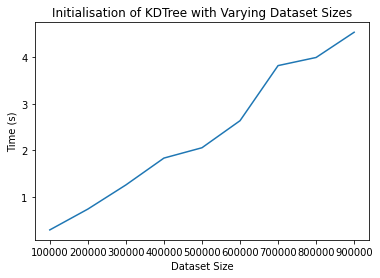

In [0]:
# Plotting a graph of KDTree performance over dataset size.


rng = np.random.RandomState(0)

times = []
xs = []

for x in range(100000, 1000000, 100000):

    rs = rng.random_sample((x, 10))
    tic = time.perf_counter()
    tree = KDTree(rs, leaf_size=2)
    toc = time.perf_counter()
    times.append(toc - tic)
    xs.append(x)

plt.plot(xs, times)
plt.title("Initialisation of KDTree with Varying Dataset Sizes")

plt.ylabel("Time (s)")
plt.xlabel("Dataset Size")
plt.show()

**Local SMOTE**

In [0]:
scalability(LOCAL_SMOTE, vehicle_scaled_df)

**Approx SMOTE**

In [0]:
scalability(GLOBAL_APPROX_SMOTE, vehicle_scaled_df)

**Exact SMOTE**

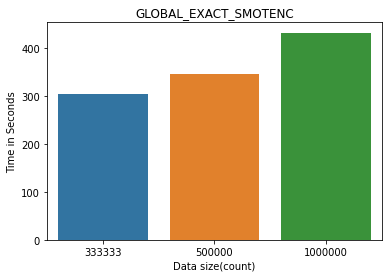

In [0]:
scalability(GLOBAL_EXACT_SMOTENC, smaller_scaled_airplane_df, [7, 8, 9, 10, 11, 12], 'Cancelled')

In [0]:
ss_airplane_df = scaled_airplane_df.limit(5000000)
ss_airplane_df.cache()

tic = time.perf_counter()
GLOBAL_EXACT_SMOTENC(ss_airplane_df, [7, 8, 9, 10, 11, 12], target='Cancelled').collect()
toc = time.perf_counter()

print("Time taken on 5,000,000 rows: %0.2f" % (toc - tic))

KDTree generated (EXACT_SMOTE)
NearestNeighbors done (EXACT_SMOTE)
Synthetic Features done (EXACT_SMOTE)
Time taken on 10,000,000 rows: 310.10
